## Predicting Bike Rentals With Machine Learning

![Rental Bikes!](bicycle-rental-6150991_1280.jpg)
(Image by Pixabay)

Washington, D.C. has communal bike sharing stations where you can rent bicycles by the hour or day. The District collects detailed data on the number of bicycles people rent by the hour and day. Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll work with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. 

In this project, we'll try to predict the total number of bikes people rented in a given hour.

#### Requirements

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [95]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

Let's look data types

In [96]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Here are the descriptions for the relevant columns:

- **instant** - A unique sequential ID number for each row
- **dteday** - The date of the rentals
- **season** - The season in which the rentals occurred
- **yr** - The year the rentals occurred
- **mnth** - The month the rentals occurred
- **hr** - The hour the rentals occurred
- **holiday** - Whether or not the day was a holiday
- **weekday** - The day of the week (as a number, 0 to 7)
- **workingday** - Whether or not the day was a working day
- **weathersit** - The weather (as a categorical variable)
- **temp** - The temperature, on a 0-1 scale
- **atemp** - The adjusted temperature
- **hum** - The humidity, on a 0-1 scale
- **windspeed** - The wind speed, on a 0-1 scale
- **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- **registered** - The number of registered riders (people who had already signed up)
- **cnt** - The total number of bike rentals (casual + registered)


All other columns are numerical except for the **dteday** column which contain datetime and there is no missing data in dataset.
Let's look the data

In [97]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


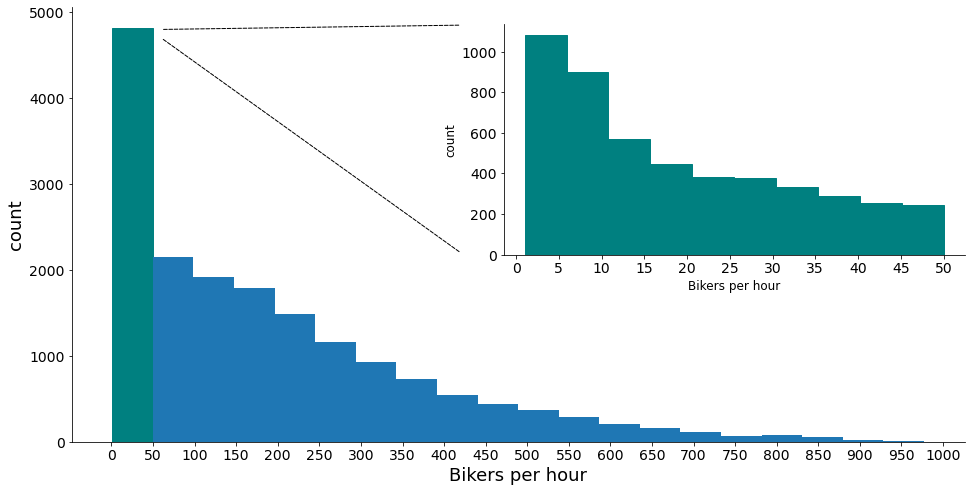

In [98]:
fig, (ax1) = plt.subplots(figsize = (16,8))


ax1.hist(bike_rentals['cnt'], bins=20)
ax1.set_xticks(range(0,1001,50))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("Bikers per hour", fontsize = '18')
ax1.set_ylabel("count", fontsize = '18')
ax1.tick_params(axis = 'x', labelsize=14)
ax1.tick_params(axis = 'y', labelsize=14)
ax1.patches[0].set_color('teal')

plt.annotate("",
              xy=(60, 4800), xycoords='data',
              xytext=(420, 4850), textcoords='data',
              arrowprops=dict(arrowstyle="-", linestyle = '--',
                              connectionstyle="arc3,rad=0."), 
              )

plt.annotate("",
              xy=(60, 4700), xycoords='data',
              xytext=(420, 2200), textcoords='data',
              arrowprops=dict(arrowstyle="-", linestyle = '--',
                              connectionstyle="arc3,rad=0."), 
              )

ax2 = plt.axes([0.5, 0.45, 0.4, 0.4])
ax2.hist(bike_rentals['cnt'][bike_rentals['cnt']<=50], bins=10)
ax2.tick_params(axis = 'x', labelsize=8)
ax2.tick_params(axis = 'y', labelsize=8)
ax2.set_xticks(range(0,51,5))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlabel("Bikers per hour", fontsize = '12')
ax2.set_ylabel("count", fontsize = '12')
ax2.tick_params(labelsize=14)

for i in range(0,10):
    ax2.patches[i].set_color('teal')


plt.show()

it is clear that **cnt** data does not follow a **Normal Distribution**, the distribution is heavily skewed to the right. This is a problem for our future modelling as many of the techniques used assume that the data follows a Normal Distribution. We should transform our target label using a log transformation.

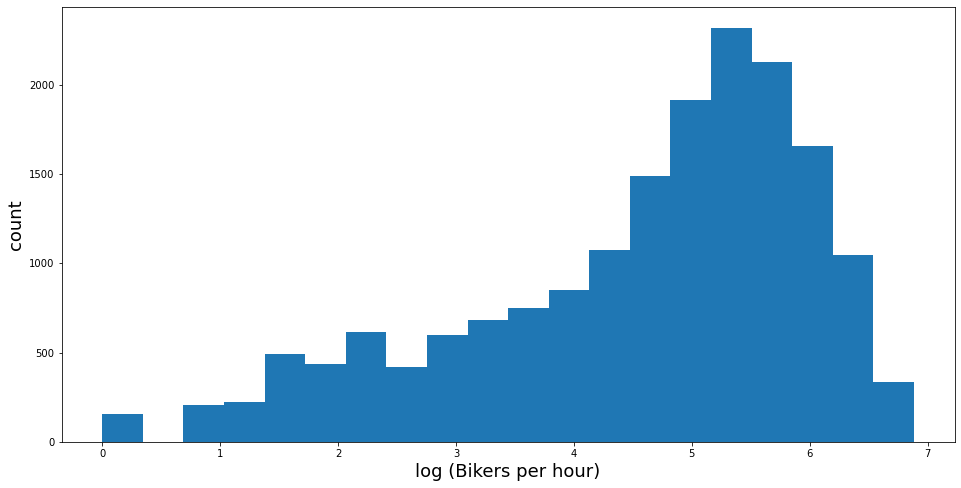

In [99]:
# transforming the target column with the natural logarithm (np.log) function
transformed_col=np.log(bike_rentals['cnt'])

fig, (ax1) = plt.subplots(figsize = (16,8))
ax1.hist(transformed_col, bins=20)
ax1.set_xlabel("log (Bikers per hour)", fontsize = '18')
ax1.set_ylabel("count", fontsize = '18')
plt.show()

Although the log tranformation did not manage to make the **cnt** column's data follow a normal distribution perfectly, it is still much better. Let us add this log-transformed label to our dataset, and use it as our target going forward.

In [100]:
bike_rentals['log_cnt'] = transformed_col

### Feature Engineering

let's look at some of the feature columns.

#### Hours and Weekdays

We are starting with the hours (**'hr'**) and days (**'weekday'**).

C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mckar\anacond

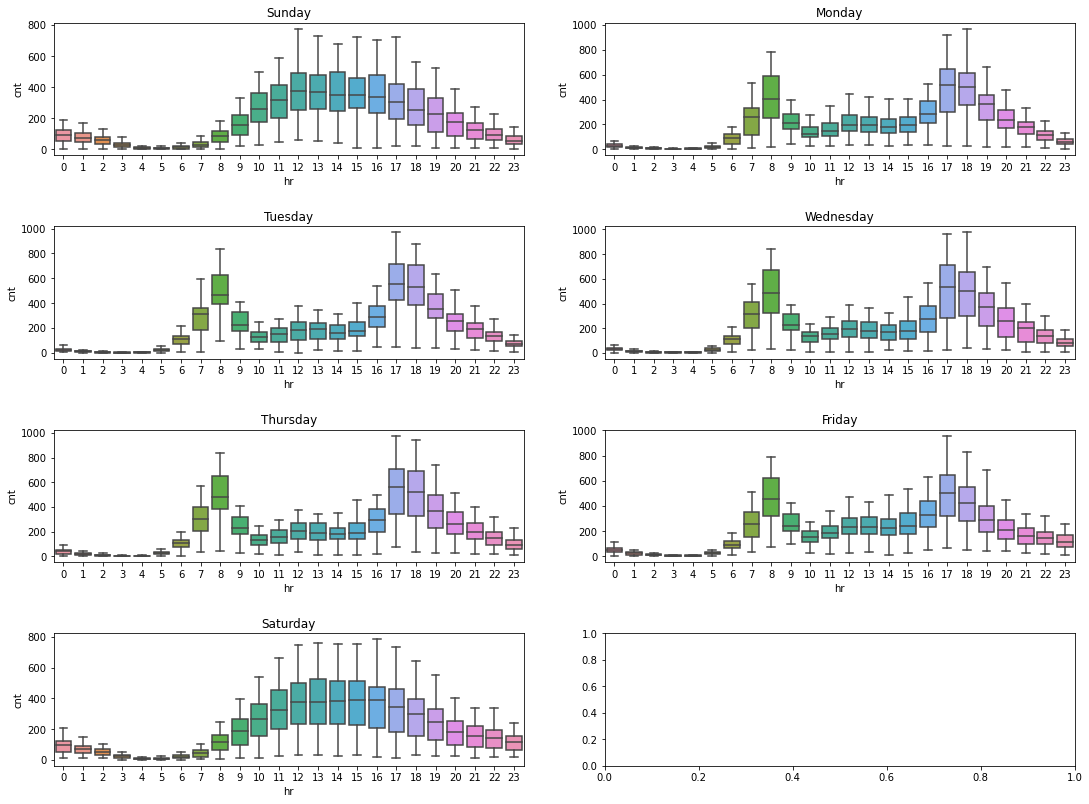

In [101]:
f_cnt_hour, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(16, 12))

f_cnt_hour.tight_layout(pad = 5)

dict_of_days = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
list_of_axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for day, curr_ax in enumerate(list_of_axes):
    sns.boxplot(bike_rentals[bike_rentals['weekday'] == day]['hr'], bike_rentals['cnt'], showfliers = False, ax = curr_ax)
    curr_ax.set_title(dict_of_days[day])



It can be said that bicycles are rented during the weekdays to and from work, and on weekends for sportive and recreational purposes.

#### Weekdays vs Weekend

C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


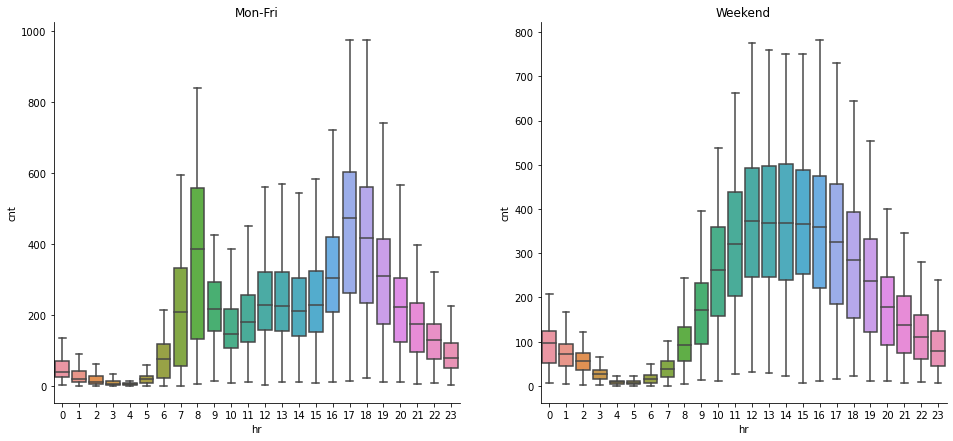

In [102]:
f_cnt_hour, (ax_cnt_workday, ax_cnt_weekend) = plt.subplots(1, 2, figsize=(16, 7))
sns.boxplot(bike_rentals[(bike_rentals['weekday'] != 0) | (bike_rentals['weekday'] != 6)]['hr'], bike_rentals['cnt'], showfliers = False, ax = ax_cnt_workday)
sns.boxplot(bike_rentals[(bike_rentals['weekday'] == 0) | (bike_rentals['weekday'] == 6)]['hr'], bike_rentals['cnt'], showfliers = False, ax = ax_cnt_weekend)
ax_cnt_workday.set_title("Mon-Fri")
ax_cnt_workday.spines['right'].set_visible(False)
ax_cnt_workday.spines['top'].set_visible(False)
ax_cnt_weekend.set_title("Weekend")
ax_cnt_weekend.spines['right'].set_visible(False)
ax_cnt_weekend.spines['top'].set_visible(False)

We can see from the figures above, there is a large difference in the number of rentals, **cnt**, based on the hour of day. Interestingly, the numbers of riders spike around 7am-8am and 5pm-6pm (17-18), corresponding to rush hour traffic, but only for regular weekdays and not in weekends.

#### Season

Let's continue with the year **yr** and **season** columns.

C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


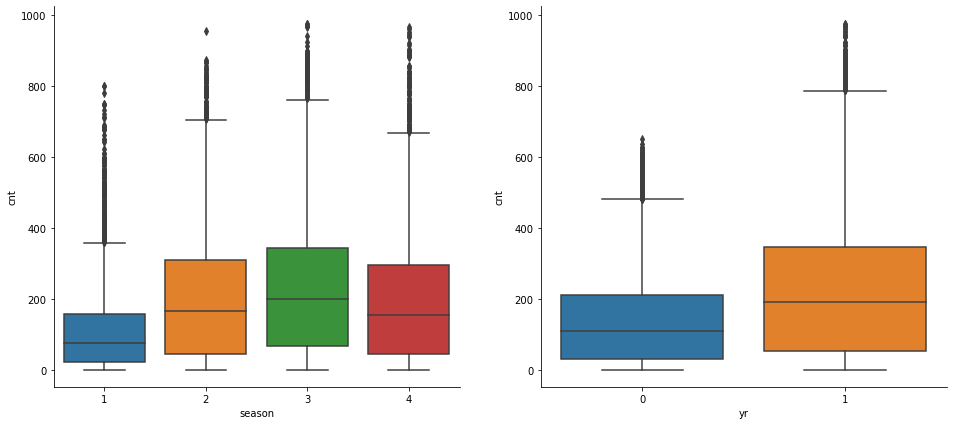

In [103]:
f_cnt_season_yr, (ax_cnt_season, ax_cnt_yr) = plt.subplots(1, 2, figsize=(16, 7))
sns.boxplot(bike_rentals['season'], bike_rentals['cnt'], ax = ax_cnt_season)
sns.boxplot(bike_rentals['yr'], bike_rentals['cnt'], ax = ax_cnt_yr)

ax_cnt_season.spines['right'].set_visible(False)
ax_cnt_season.spines['top'].set_visible(False)
ax_cnt_yr.spines['right'].set_visible(False)
ax_cnt_yr.spines['top'].set_visible(False)

Seasonal changes can be observed with Spring (1) being the least busy. Bike rentals seems to have increased over the two years that the dataset covers **yr** column.

#### Weather

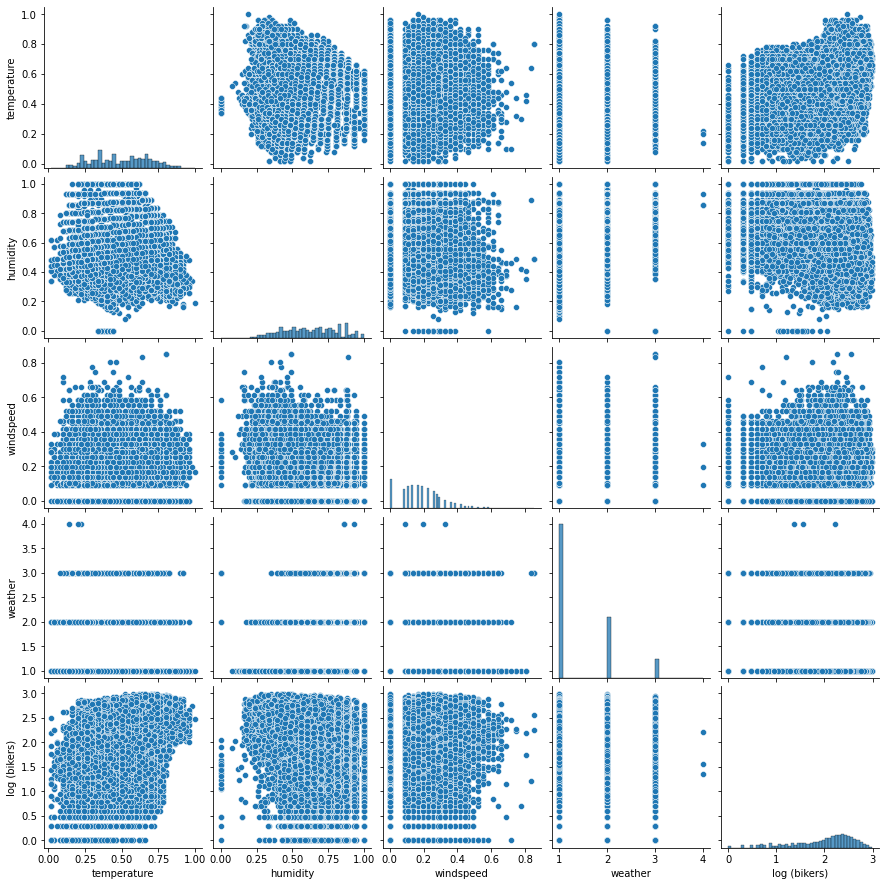

In [104]:
df_pairplot = pd.DataFrame()
df_pairplot['temperature'] = bike_rentals['temp']
df_pairplot['humidity'] =  bike_rentals['hum']
df_pairplot['windspeed'] =  bike_rentals['windspeed']
df_pairplot['weather'] = bike_rentals['weathersit']
df_pairplot['log (bikers)'] = np.log10(bike_rentals['cnt'])
sns.pairplot(df_pairplot)

From the pairplot above we are mostly interested in the bottom row, showing the effect of each of these parameters on the number of bikers.

Here we can see that high temperatures **temp**, high **windspeed** and low humidity **hum** are all correlated with a high number of bikers. The weather **weathersit** data seems to be less correlated with the number of bikers.

#### Spliting the data Train and Test

Let's split our data to train and test. We select 80% of the rows in bike_rentals to be part of the training set using the sample method on bike_rentals.

In [105]:
training = bike_rentals.sample((int(bike_rentals.shape[0]*0.8)))
print("training pct of dataset: " + str(training.shape[0]/bike_rentals.shape[0]*100))
test = pd.merge(training, bike_rentals, how='outer', indicator=True)
test = test[test['_merge'] == 'right_only'].copy()
test.drop('_merge', axis=1)
print("test pct of dataset: " + str(test.shape[0]/bike_rentals.shape[0]*100))

training pct of dataset: 79.99884918579895
test pct of dataset: 20.001150814201047


#### Features and Target Column

Let's define our feature columns and target column to prepare dataset for our Machine Learning models. We'll create a list of predictor columns to use in training and predictions. 

In [106]:
features = training.columns.tolist()
# list_of_features_to_drop = ['cnt', 'casual', 'dteday', 'registered', 'log_cnt', 'instant', 'cnt_z_score', 'atemp', 'workingday']
# features = [x for x in features if (x not in list_of_features_to_drop)]
# print("Feature cols: " + str(features))
# print("No. of features: " + str(len(features)) + '\n')

target_col = 'log_cnt'
print("Features col: " + str(features))
print("Target col: " + str(target_col))

Features col: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'log_cnt']
Target col: log_cnt


Let's check the corralation between log_cnt and features columns:

C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


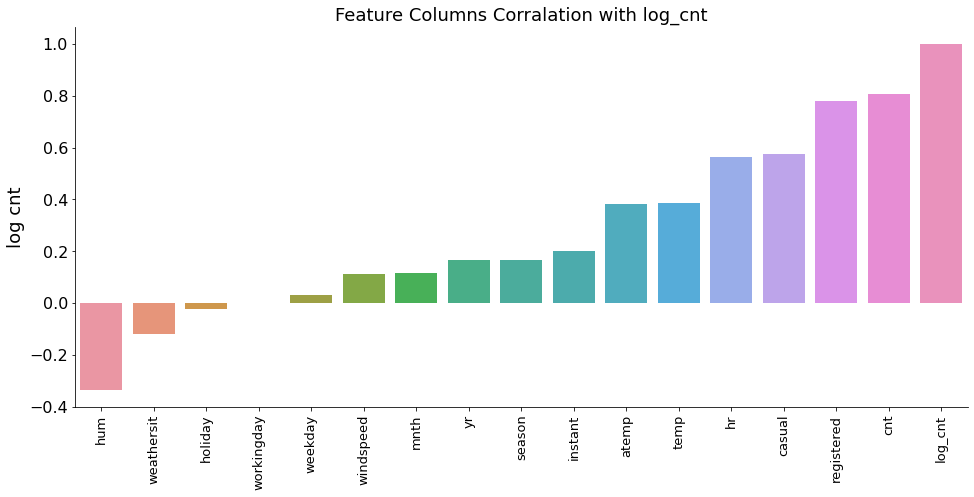

In [107]:
corr = bike_rentals.corr()
cnt_corr = corr['log_cnt'].sort_values()

f, ax = plt.subplots(figsize=(16, 7))
ax = sns.barplot(cnt_corr.index, cnt_corr)
ax.set_title("Feature Columns Corralation with log_cnt", fontsize = '18')
ax.set_ylabel("log cnt", fontsize = '18')
ax.tick_params(axis = 'x', labelsize = 13, rotation=90)
ax.tick_params(axis = 'y', labelsize = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

When the columns are sorted based on corralation with **log_cnt**, we can see that  'cnt', 'casual', 'dteday', 'registered', 'log_cnt', 'instant', 'cnt_z_score', 'atemp', 'workingday' columns have smallest corralation. So our features list should exclude the **'cnt', 'casual', 'dteday', 'registered', 'log_cnt', 'instant', 'cnt_z_score', 'atemp', 'workingday'** columns which will not be useful for the predictions. Let's remove them:

In [108]:
features = training.columns.tolist()
list_of_features_to_drop = ['cnt', 'casual', 'dteday', 'registered', 'log_cnt', 'instant', 'cnt_z_score', 'atemp', 'workingday']
features = [x for x in features if (x not in list_of_features_to_drop)]
print("Updated Feature columns: " + str(features))
print("No. of features: " + str(len(features)) + '\n')

target_col = 'log_cnt'

print("Target col: " + str(target_col))

Updated Feature columns: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed']
No. of features: 10

Target col: log_cnt


the corr method on the bike_rentals dataframe to explore how each column is correlated with cnt.

C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


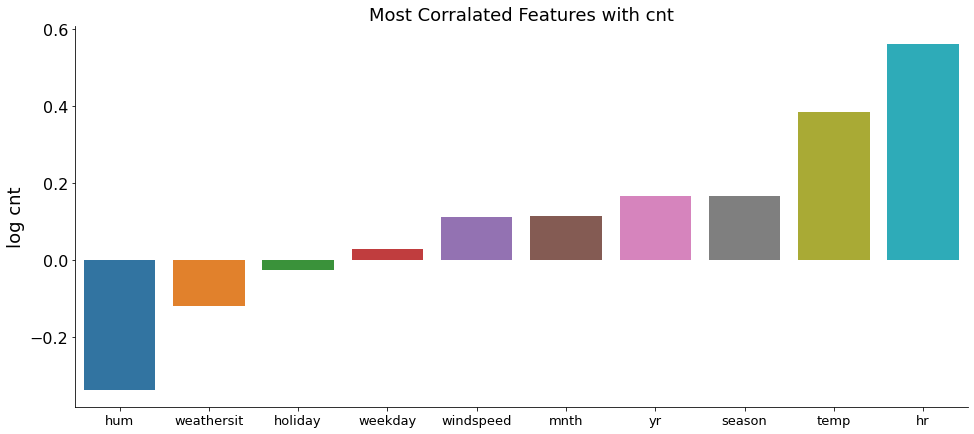

In [109]:
corr = bike_rentals.corr()
cnt_corr = corr['log_cnt'].sort_values()
cnt_corr = cnt_corr.drop(['cnt', 'registered', 'casual', 'instant', 'log_cnt', 'atemp', 'workingday']) # Let's remove the target column and those directly derived from it

f, ax = plt.subplots(figsize=(16, 7))
ax = sns.barplot(cnt_corr.index, cnt_corr)
ax.set_title("Most Corralated Features with cnt", fontsize = '18')
ax.set_ylabel("log cnt", fontsize = '18')
ax.tick_params(axis = 'x', labelsize = 13)
ax.tick_params(axis = 'y', labelsize = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Our model will be built these features: **'hum', 'weathersit', 'holiday', 'weekday', 'windspeed', 'mnth', 'yr', 'season',   'temp', 'hr'**.

### Model Training, Fit and Predictions

Let's start to build the model and check fitting of the model to data. 

#### Decision Tree Regressor

In [110]:
dtr = DecisionTreeRegressor(random_state=1)
dtr.fit(training[features], training[target_col])

train_pred = dtr.predict(training[features])
train_mse = mean_squared_error(training[target_col], train_pred)
train_rmse = np.sqrt(train_mse)
train_r2score = r2_score(training[target_col], train_pred)
train_mae = mean_absolute_error(np.exp(training[target_col]), np.exp(train_pred))

test_pred = dtr.predict(test[features])
test_mse = mean_squared_error(test[target_col], test_pred)
test_rmse = np.sqrt(test_mse)
test_r2score = r2_score(test[target_col], test_pred)
test_mae = mean_absolute_error(np.exp(test[target_col]), np.exp(test_pred))

print("TRAIN ERRORS:")
print("MSE:", train_mse)
print("RMSE:", train_rmse)
print("R2 SCORE:", train_r2score)
print("MAE:", train_mae)
print("-"*20)
print("TEST ERRORS:")
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("R2 SCORE:", test_r2score)
print("MAE:", test_mae)

TRAIN ERRORS:
MSE: 0.00011782155388053735
RMSE: 0.010854563735154784
R2 SCORE: 0.9999468204082141
MAE: 0.010357476803567588
--------------------
TEST ERRORS:
MSE: 0.21967131222052155
RMSE: 0.4686910626633727
R2 SCORE: 0.899194066375899
MAE: 35.057249712313


One of the symptoms of an overfit model is an R-squared value that is too high. We clearly see an overfitting when we use default parameters. This is expected when using Decision Trees.

#### Hyperparameter optimization

We'll built two different alternative tree based models (Decision Tree and Random Forest) and to find the parameters that will yield the best models. Our problem is predicting bike sales. So it's a regression problem. 

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model. Therefore, we will use  Decision tree regressor. But it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [111]:
def decision_tree_optimize_1(test_dataframe, msl, md):
    dtr = DecisionTreeRegressor(min_samples_leaf = msl, max_depth = md)
    
    dtr.fit(training[features], training[target_col])

    predictions = dtr.predict(test_dataframe[features])
    mae = mean_absolute_error(np.exp(test_dataframe[target_col]), np.exp(predictions)) 
    
    return mae

def decision_tree_optimize_2(test_dataframe, mss, mf):
    dtr = DecisionTreeRegressor(min_samples_split = mss, max_features = mf)
    
    dtr.fit(training[features], training[target_col])

    predictions = dtr.predict(test_dataframe[features])
    mae = mean_absolute_error(np.exp(test_dataframe[target_col]), np.exp(predictions)) 
    
    return mae

There are three main ways to combat overfitting:

- "Prune" the tree after we build it to remove unnecessary leaves.
- Use ensembling to blend the predictions of many trees.
- Restrict the depth of the tree while we're building it.


#### Pre-Pruning:

The pre-pruning technique refers to the early stopping of the growth of the decision tree. The pre-pruning technique involves tuning the hyperparameters of the decision tree model prior to the training pipeline. The hyperparameters of the decision tree including **max_depth, min_samples_leaf, min_samples_split** can be tuned to early stop the growth of the tree and prevent the model from overfitting.

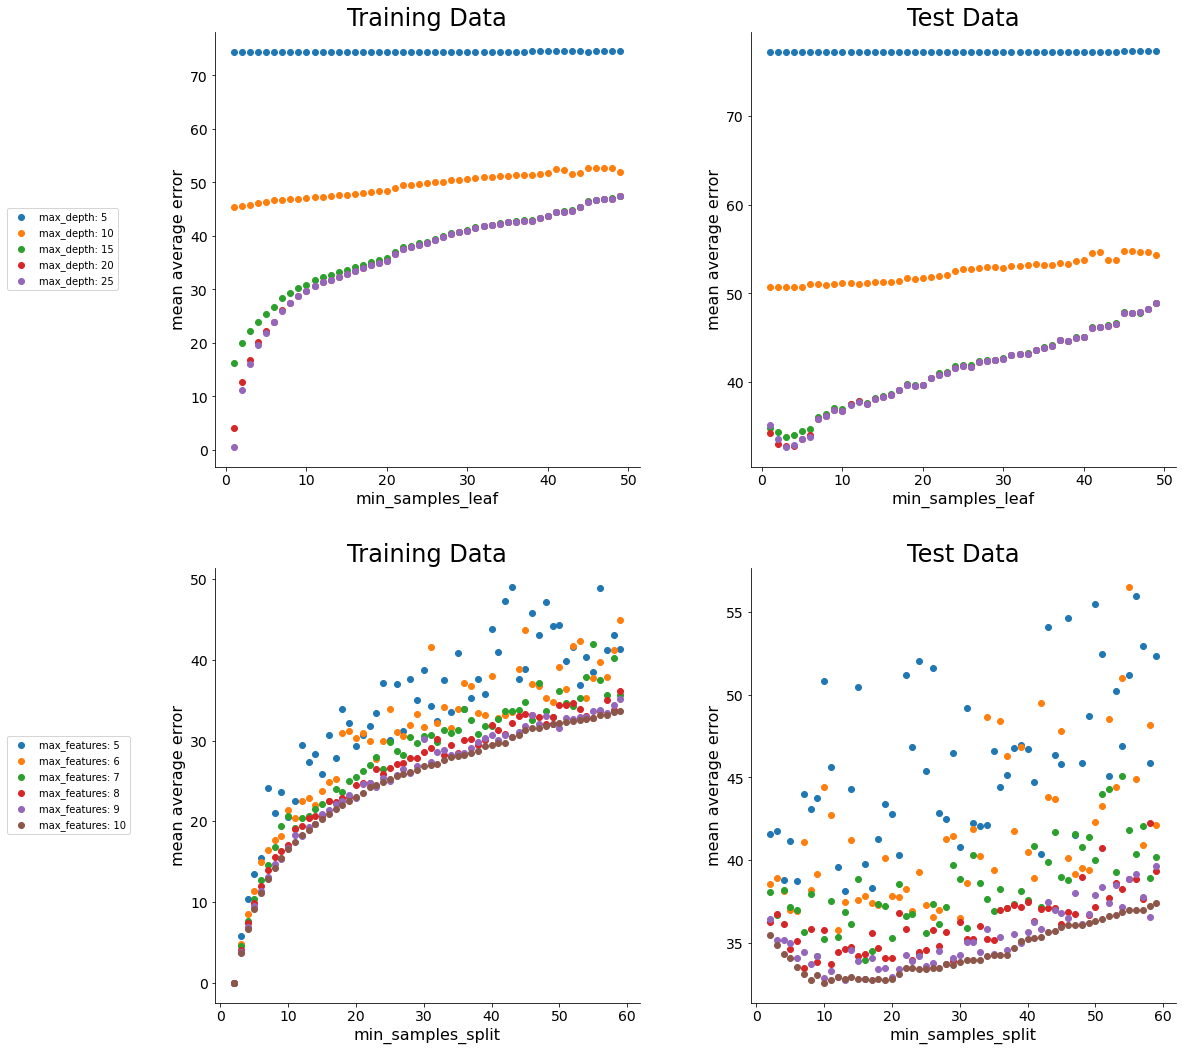

In [112]:
def plot_two_features(outer_feature_name, inner_feature_name, outer_feature_list, inner_feature_list, training_ax, test_ax, decision_tree_function):
    for index, i in enumerate(outer_feature_list):
        x_vals = []
        training_vals = []
        test_vals = []
        colors = ['orange', 'green', 'red', 'blue', 'purple', 'yellow', 'black']

        for j in inner_feature_list:
                x_vals.append(j)
                training_vals.append(decision_tree_function(training, j, i))
                test_vals.append(decision_tree_function(test, j, i))

        training_ax.scatter(x_vals, training_vals, label = outer_feature_name+": "+ str(i), cmap=plt.get_cmap('Wistia'))
        training_ax.legend(loc='center left', bbox_to_anchor=(-0.5, 0.5))
        training_ax.set_xlabel(inner_feature_name, fontsize = 16.0)
        training_ax.set_ylabel("mean average error", fontsize = 16.0)
        training_ax.tick_params(labelsize=14)
        training_ax.set_title("Training Data", fontsize = 24.0)
        training_ax.spines['right'].set_visible(False)
        training_ax.spines['top'].set_visible(False)
        
        
        test_ax.scatter(x_vals, test_vals, label = outer_feature_name+": "+ str(i), cmap=plt.get_cmap('Wistia'))
        test_ax.set_xlabel(inner_feature_name, fontsize = 16.0)
        test_ax.set_ylabel("mean average error", fontsize = 16.0)
        test_ax.tick_params(labelsize=14)
        #test_ax.set_ylim(0,75)
        test_ax.set_title("Test Data", fontsize = 24.0)
        test_ax.spines['right'].set_visible(False)
        test_ax.spines['top'].set_visible(False)

min_samples_leaf = range(1,50)
max_depth_range = range(5,30,5)
min_samples_split = range(2,60)
max_features = range(5,len(features)+1,1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,16))
fig.tight_layout(pad=8.0)

plot_two_features("max_depth", "min_samples_leaf", max_depth_range, min_samples_leaf, ax1, ax2, decision_tree_optimize_1)
plot_two_features("max_features", "min_samples_split", max_features, min_samples_split, ax3, ax4, decision_tree_optimize_2)
    
plt.show()

We have tweaked the different parameters including **min_samples_leaf, max_depth_range, min_samples_split and max_features**. It seems that min_samples_leaf = 10, max_depth = 25, min_samples_split = 15 will give best solution, bigger parameter will not bring down the error metric.

#### Optimized Decision Tree Regressor

Decision Tree optimized dataset:
training_mae: 29.714763176253857
training_mse: 2496.5586665392607
training_rmse: 49.96557481445861

test_mae: 36.701071738444355
test_mse: 3950.775275629946
test_rmse: 62.85519290901863



<function matplotlib.pyplot.show(close=None, block=None)>

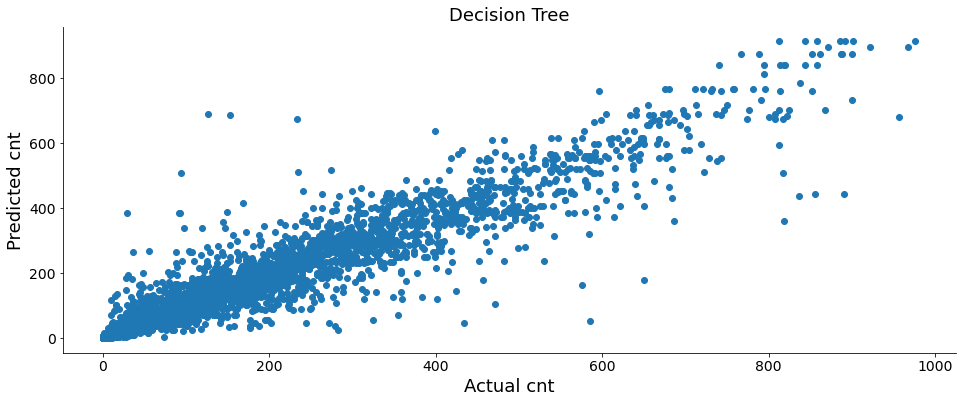

In [113]:
def decision_regression(training, test, features):

    dtr = DecisionTreeRegressor(min_samples_leaf = 10, max_depth = 25, min_samples_split = 15)

    dtr.fit(training[features], training[target_col])

    training_predictions = dtr.predict(training[features])
    training_mae = mean_absolute_error(np.exp(training[target_col]), np.exp(training_predictions))
    training_mse = mean_squared_error(np.exp(training[target_col]), np.exp(training_predictions))
    training_rmse = training_mse**(1/2)

    test_predictions = dtr.predict(test[features])
    test_mae = mean_absolute_error(np.exp(test[target_col]), np.exp(test_predictions))
    test_mse = mean_squared_error(np.exp(test[target_col]), np.exp(test_predictions))
    test_rmse = test_mse**(1/2)


    print("training_mae: " + str(training_mae))
    print("training_mse: " + str(training_mse))
    print("training_rmse: " + str(training_rmse))
    print("")
    print("test_mae: " + str(test_mae))
    print("test_mse: " + str(test_mse))
    print("test_rmse: " + str(test_rmse))
    print("")
    
    return test_predictions

print("Decision Tree optimized dataset:")


old_model1 = decision_regression(training, test, features)
comparison = test.copy()
comparison['cnt_guess_tree'] = np.exp(old_model1)

fig, ax = plt.subplots(1, figsize=(16,6))

ax.scatter(comparison['cnt'], comparison['cnt_guess_tree'])
ax.set_title("Decision Tree", fontsize = '18')
ax.set_xlabel("Actual cnt", fontsize = '18')
ax.set_ylabel("Predicted cnt", fontsize = '18')
ax.tick_params(labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.show

#### Random Forest Regressor

Let's build the Random Forest model and then tweak the different parameters including **min_samples_leaf, max_depth_range, min_samples_split and max_features** to optimize the **Random Forest**.

In [114]:
rfr = RandomForestRegressor(random_state=1)
rfr.fit(training[features], training[target_col])

train_pred = rfr.predict(training[features])
train_mse = mean_squared_error(training[target_col], train_pred)
train_rmse = np.sqrt(train_mse)
train_r2score = r2_score(training[target_col], train_pred)
train_mae = mean_absolute_error(np.exp(training[target_col]), np.exp(train_pred))

test_pred = rfr.predict(test[features])
test_mse = mean_squared_error(test[target_col], test_pred)
test_rmse = np.sqrt(test_mse)
test_r2score = r2_score(test[target_col], test_pred)
test_mae = mean_absolute_error(np.exp(test[target_col]), np.exp(test_pred))

print("TRAIN ERRORS:")
print("MSE:", train_mse)
print("RMSE:", train_rmse)
print("R2 SCORE:", train_r2score)
print("MAE:", train_mae)
print("-"*20)
print("TEST ERRORS:")
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("R2 SCORE:", test_r2score)
print("MAE:", test_mae)

TRAIN ERRORS:
MSE: 0.0176909385650749
RMSE: 0.133007287638967
R2 SCORE: 0.9920150697371248
MAE: 9.932335245874572
--------------------
TEST ERRORS:
MSE: 0.11743086442048531
RMSE: 0.3426818705745685
R2 SCORE: 0.946111634675771
MAE: 26.364304118452694


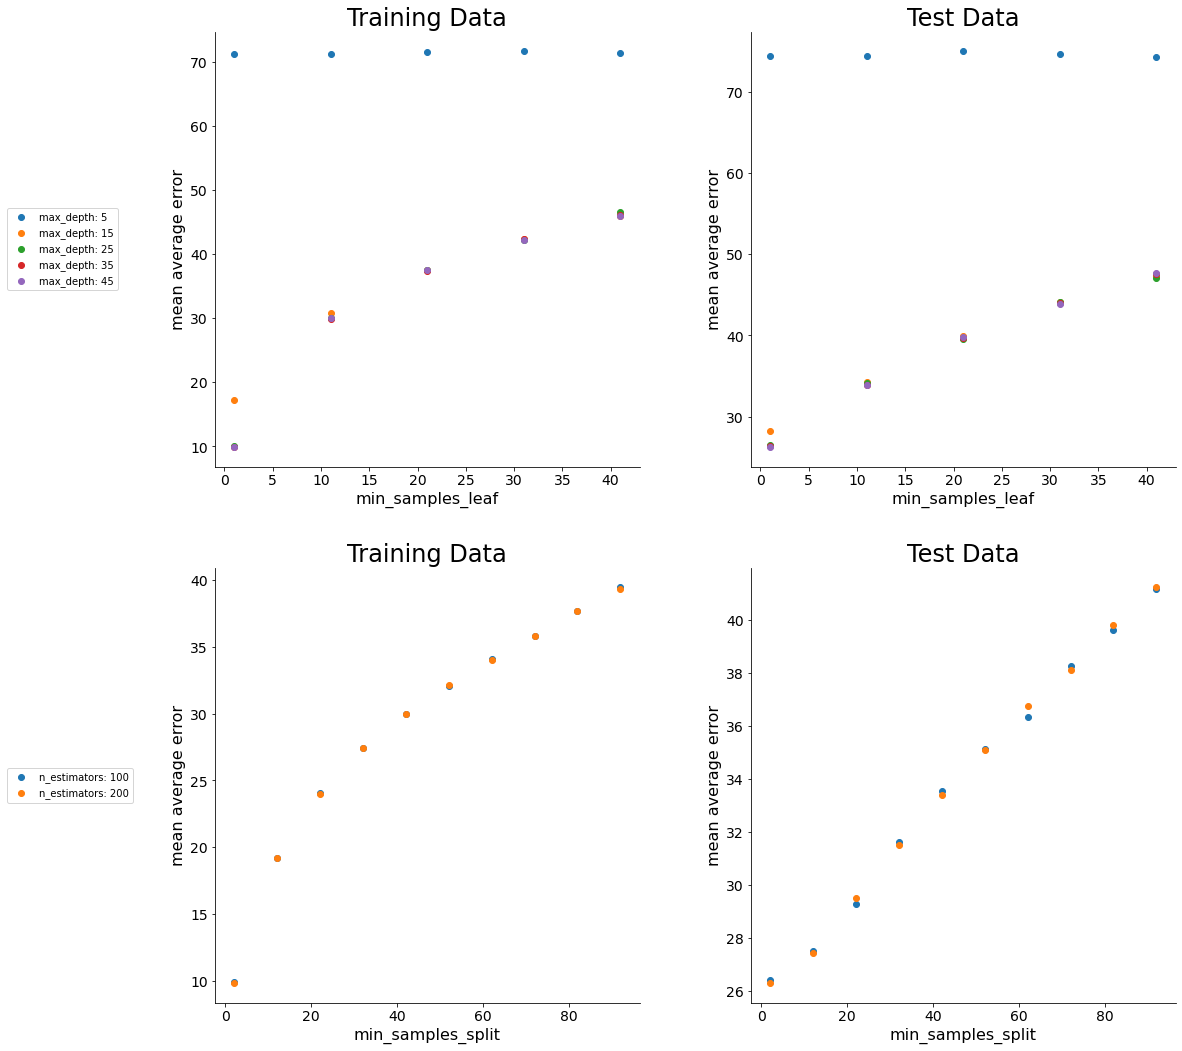

In [115]:
def random_forest_optimize_1(test_dataframe, msl, md):
    rfr = RandomForestRegressor(min_samples_leaf = msl, max_depth = md)
    rfr.fit(training[features], training[target_col])

    predictions = rfr.predict(test_dataframe[features])
    mae = mean_absolute_error(np.exp(test_dataframe[target_col]), np.exp(predictions))

    return mae

def random_forest_optimize_2(test_dataframe, mss, mf):
    rfr = RandomForestRegressor(min_samples_split = mss, n_estimators = mf)
    rfr.fit(training[features], training[target_col])

    predictions = rfr.predict(test_dataframe[features])
    mae = mean_absolute_error(np.exp(test_dataframe[target_col]), np.exp(predictions))

    return mae

min_samples_leaf = range(1,50,10)
max_depth_range = range(5,55,10)
min_samples_split = range(2,100,10)
n_estimators = range(100,201,100)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,16))
fig.tight_layout(pad=8.0)

plot_two_features("max_depth", "min_samples_leaf", max_depth_range, min_samples_leaf, ax1, ax2, random_forest_optimize_1)
plot_two_features("n_estimators", "min_samples_split", n_estimators, min_samples_split, ax3, ax4, random_forest_optimize_2)
    
plt.show()

#### Optimized Random Forest Regressor

We have tweaked the different parameters including min_samples_leaf, max_depth_range, min_samples_split and max_features. It seems that min_samples_leaf = 10, max_depth = 25, min_samples_split = 20 are sweet spot.

Random Forest optimized dataset:
training_mae: 29.021363676602277
training_mse: 2327.2030939285733
training_rmse: 48.24109341555779

test_mae: 33.35084585158978
test_mse: 3118.1263928291505
test_rmse: 55.84018618189906
test_r2score: 0.9282595868391286



<function matplotlib.pyplot.show(close=None, block=None)>

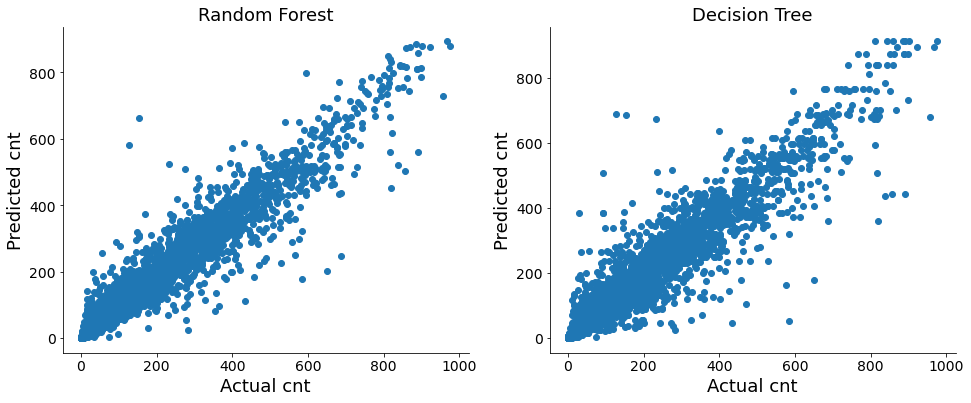

In [119]:
def random_forest_regression(training, test, features):

    rfr = RandomForestRegressor(min_samples_leaf = 10, max_depth = 25, min_samples_split = 20)

    rfr.fit(training[features], training[target_col])

    training_predictions = rfr.predict(training[features])
    training_mae = mean_absolute_error(np.exp(training[target_col]), np.exp(training_predictions))
    training_mse = mean_squared_error(np.exp(training[target_col]), np.exp(training_predictions))
    training_rmse = training_mse**(1/2)

    test_predictions = rfr.predict(test[features])
    test_mae = mean_absolute_error(np.exp(test[target_col]), np.exp(test_predictions))
    test_mse = mean_squared_error(np.exp(test[target_col]), np.exp(test_predictions))
    test_rmse = test_mse**(1/2)
    test_r2score = r2_score(test[target_col], test_predictions)
    
    print("training_mae: " + str(training_mae))
    print("training_mse: " + str(training_mse))
    print("training_rmse: " + str(training_rmse))
    print("")
    print("test_mae: " + str(test_mae))
    print("test_mse: " + str(test_mse))
    print("test_rmse: " + str(test_rmse))
    print("test_r2score: " + str(test_r2score))
    print("")
    
    return test_predictions

print("Random Forest optimized dataset:")
old_model2 = random_forest_regression(training, test, features)

comparison['cnt_guess_forest'] = np.exp(old_model2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.scatter(comparison['cnt'], comparison['cnt_guess_forest'])
ax1.set_title("Random Forest", fontsize = '18')
ax1.set_xlabel("Actual cnt", fontsize = '18')
ax1.set_ylabel("Predicted cnt", fontsize = '18')
ax1.tick_params(labelsize=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.scatter(comparison['cnt'], comparison['cnt_guess_tree'])
ax2.set_title("Decision Tree", fontsize = '18')
ax2.set_xlabel("Actual cnt", fontsize = '18')
ax2.set_ylabel("Predicted cnt", fontsize = '18')
ax2.tick_params(labelsize=14)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show

C:\Users\mckar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Test RMSE Errors')

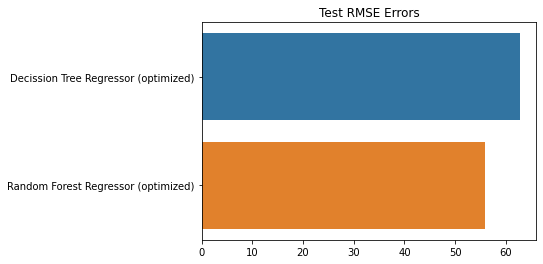

In [120]:
test_rmse_errors = [62.85519290901863, 55.84018618189906]

models = ['Decission Tree Regressor (optimized)',
         'Random Forest Regressor (optimized)']

ax = plt.subplot()
sns.barplot(test_rmse_errors, models, orient='h')
plt.title("Test RMSE Errors")



It's clear that the Random Forest Regressor have least RMSE values. 

In [121]:
#Example predictions based on the tree-model dataset
comparison[['cnt', 'cnt_guess_tree', 'cnt_guess_forest']].head(25)

,cnt,cnt_guess_tree,cnt_guess_forest
13903,14,37.247091,72.408895
13904,94,130.017456,141.903971
13905,53,29.268246,58.465061
13906,70,29.268246,69.197422
13907,76,65.085474,52.611251
13908,51,48.287226,53.046814
13909,12,15.346161,17.693006
13910,2,1.814064,1.521790
13911,179,83.396673,124.238740
13912,97,67.296994,65.143335


### Conclusion

We managed to build two machine learning models (decision tree and random forest models) for predicting the number of bike rentals in Washington D.C. Here we showed the difference feature engineering can make with regards to model optimization, between models.

As a result of the analysis, we can conclude that the random forests algorithm is the most accurate for the given task and data. The results of the best model are the following:

    test_mae: 33.35084585158978
    test_mse: 3118.1263928291505
    test_rmse: 55.84018618189906
    0.92 r2 score

The best performing model was the Random Forest, which had a test RMSE value of 56.15372220575069. 